In [283]:
import numpy as np
import pandas as pd
import glob
import math
import os 
from random import shuffle
import cv2
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [284]:
sampling_rate = 1024
gesture_size = 1536 #each gesture records 1.5 seconds
time_ms = (1/sampling_rate) * 1000 #sampling time in ms
nfft = 64 #window length -> 256 samples - 125 ms and 128 samples - 62.5ms
overlap = 58 #87.5% overlapping [128 - 112ms and 256 - 224ms]
zp =  0
T_sample = 1.5 #in seconds

train_data = []
test_data = []

gesture_mapping = {'double_tap': 4,
                   'tick': 3,
                   'swipe': 2,
                   'up_to_down': 1,
                   'nothing': 0
                   }

In [285]:
path = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Subject1'                   
image_paths = os.listdir(path)
shuffle(image_paths)
#print(image_paths)

path2 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Subject2'                   
image_paths2 = os.listdir(path2)
shuffle(image_paths2)

path1 = r'/home/ge73pal/Documents/Thesis_projectgit/ml/ml_on_mcu/ml_radar/Radar/Data/Images/1024_64nfft/Grayscale_rfft/Test'                   
image_paths1 = os.listdir(path1)
shuffle(image_paths1)

img_path1 = os.path.join(path, 'double_tap-11_rfft.png')
image1 = cv2.imread(img_path1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
print(image1.shape)
print(type(image1[0][0]))

IMAGE_HEIGHT = int(image1.shape[0])
IMAGE_WIDTH = int(image1.shape[1])
print(IMAGE_HEIGHT)
print(IMAGE_WIDTH)

(32, 247)
<class 'numpy.uint8'>
32
247


In [286]:
def label_int(word_label):
    label = gesture_mapping[word_label]
    label_arr = np.zeros(5)
    label_arr[label] = 1
    return label_arr

In [287]:
for img in image_paths:
    word_label = img.split('-')[0]
    label = label_int(word_label)
    img_path = os.path.join(path, img)
    #image = PIL.Image.open(img_path)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = image.astype('float') / 255.0
    train_data.append([image, label])

for img2 in image_paths2:
    word_label2 = img2.split('-')[0]
    label2 = label_int(word_label2)
    img_path2 = os.path.join(path2, img2)
    #image = PIL.Image.open(img_path)
    image2 = cv2.imread(img_path2)
    image2 = cv2.resize(image2, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    #image = image.astype('float') / 255.0
    train_data.append([image2, label2])

for img_t in image_paths1:
    word_label_t = img_t.split('-')[0]
    label_t = label_int(word_label_t)
    img_path1 = os.path.join(path1, img_t)
    #image_t = PIL.Image.open(img_path1)
    image_t = cv2.imread(img_path1)
    image_t = cv2.resize(image_t, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2GRAY)
    #image_t = image_t.astype('float') / 255.0
    test_data.append([image_t, label_t])
       

In [288]:
#parameters
data_size = len(train_data)+len(test_data)
input_shape = image.shape  
split_ratio = 0.8
train_size = int(data_size * split_ratio)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 5
LEARNING_RATE = 3e-4
MOMENTUM = 0.8
DECAY = 1e-06

print(train_data[0])
print("total number of images = " + str(data_size))
print("input image shape = " + str(input_shape))

#train_data = data[:train_size]
train_images = np.array([i[0] for i in train_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
train_labels = np.array([i[1] for i in train_data])

#test_data = data[train_size:]
X_test = np.array([i[0] for i in test_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
Y_test = np.array([i[1] for i in test_data])

X_train, X_val, Y_train, Y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size=0.15, 
                                                  stratify=np.array(train_labels), 
                                                  random_state=42)


print ("number of training + validation examples = " + str(train_images.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


[array([[  0,   0,   0, ...,   0,   0,   2],
       [  0,  67,   0, ...,  67,  67, 215],
       [ 67,   0,   0, ...,  67, 107,  67],
       ...,
       [  0,  67,   0, ...,   0,  67,   0],
       [ 67,  67,   0, ...,  67,   0,  67],
       [  0,  67,   0, ...,  67,  67,   0]], dtype=uint8), array([0., 0., 0., 1., 0.])]
total number of images = 2000
input image shape = (32, 247)
number of training + validation examples = 1900
number of test examples = 100
X_train shape: (1615, 32, 247)
Y_train shape: (1615, 5)
X_val shape: (285, 32, 247)
Y_val shape: (285, 5)
X_test shape: (100, 32, 247)
Y_test shape: (100, 5)


[0. 0. 1. 0. 0.]


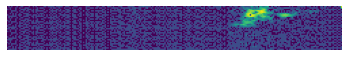

In [289]:
#plt.imshow(data[15][0])
#plt.axis('off')
#print(data[15][1])


plt.imshow(X_train[0])
plt.axis('off')
print(Y_train[0])


In [294]:
def get_model():
    model = tf.keras.Sequential()#Sequential()

    # Input Layer
    model.add(Activation(None, input_shape=(32, 247, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(12, kernel_size = (3, 3), activation='relu', input_shape=(32, 247, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    #model.add(Dropout(0.2)) 
    model.add(Dense(5, activation = 'softmax', kernel_regularizer=regularizers.l2(0.001), 
                activity_regularizer=regularizers.l2(0.001)))
    
    sgd = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
    adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ['accuracy'])
    print('model prepared...')
    return model

In [295]:
model = get_model()

model prepared...


In [296]:
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_val,Y_val))

Epoch 1/50
51/51 [==============================] - 3s 50ms/step - loss: 1.4194 - accuracy: 0.4248 - val_loss: 1.5735 - val_accuracy: 0.2316
Epoch 2/50
51/51 [==============================] - 2s 48ms/step - loss: 0.8706 - accuracy: 0.6557 - val_loss: 1.4930 - val_accuracy: 0.2351
Epoch 3/50
51/51 [==============================] - 2s 47ms/step - loss: 0.6025 - accuracy: 0.7858 - val_loss: 1.2092 - val_accuracy: 0.5404
Epoch 4/50
51/51 [==============================] - 2s 47ms/step - loss: 0.4328 - accuracy: 0.8545 - val_loss: 1.0407 - val_accuracy: 0.6211
Epoch 5/50
51/51 [==============================] - 2s 48ms/step - loss: 0.3099 - accuracy: 0.8929 - val_loss: 0.8175 - val_accuracy: 0.6947
Epoch 6/50
51/51 [==============================] - 2s 48ms/step - loss: 0.2770 - accuracy: 0.9059 - val_loss: 0.9160 - val_accuracy: 0.6982
Epoch 7/50
51/51 [==============================] - 2s 48ms/step - loss: 0.2342 - accuracy: 0.9269 - val_loss: 0.4899 - val_accuracy: 0.8035
Epoch 8/50
51

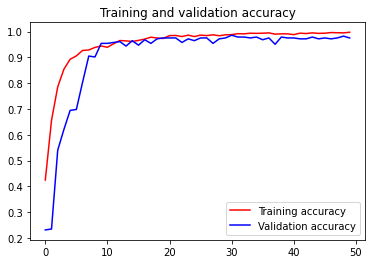

<Figure size 432x288 with 0 Axes>

In [297]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [298]:
predictions = model.evaluate(X_test, Y_test)
print ("Loss = " + str(predictions[0]))
#print ("Test Accuracy = " + str(predictions[1]))
print("Model has an accuracy of {0:.2f}%".format(predictions[1] * 100))

4/4 [==============================] - 0s 8ms/step - loss: 0.1724 - accuracy: 0.9700
Loss = 0.172440305352211
Model has an accuracy of 97.00%


In [299]:
from sklearn.metrics import confusion_matrix

tt= model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(tt,axis=1))
print(cm)

[[20  0  0  0  0]
 [ 0 19  0  0  1]
 [ 0  0 18  2  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


(32, 247)
[[4.8405550e-06 2.1653774e-04 1.9199774e-04 1.9722152e-06 9.9958462e-01]]
[0. 0. 0. 0. 1.]


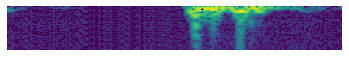

In [300]:
index = 46
print(X_test[index].shape)
xi = X_test[index].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH)
#print(xi.shape)
#print(X_test.shape)

tt= model.predict(xi)
print(tt)

plt.axis('off')
plt.imshow(X_test[index])
print(Y_test[index])


In [301]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_25 (Activation)   (None, 32, 247, 1)        0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 32, 247, 1)        4         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 30, 245, 12)       120       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 15, 122, 12)       0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 15, 122, 12)       48        
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 13, 120, 4)        436       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 6, 60, 4)        

In [302]:
model.save('my_model.h5')